In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score, mean_squared_error  
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import optuna

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import re

In [3]:
from perform_visualization import perform_eda, perform_eda_short, performance_visualizations

In [4]:
random_seed = 42
early_stopping_round = 100

In [5]:
def add_exp_num(X):
    tracers_num = len(np.unique(X["Tracer"]))
    distances_num = len(np.unique(X["distances"]))
    experiment_num = []
    for exp in range(X.shape[0]//(tracers_num*distances_num)):
        experiment_num.extend(list(np.ones(tracers_num*distances_num) * (exp + 1)))
    X["experiment_num"] = experiment_num
    return X

In [6]:
def data_split(X, y, test_size = 0.2, valid_size = None, eval_size = None, random_seed = random_seed):
    rng = np.random.default_rng(seed=random_seed)
    
    experiment_nums = X["experiment_num"].unique()
    total_experiments = len(experiment_nums)
    
    n_test = int(test_size * total_experiments)
    
    splits = {}
    remaining_exps = set(experiment_nums)
    
    test_experiments = set(rng.choice(list(remaining_exps), n_test, replace=False))
    remaining_exps -= test_experiments
    splits['test'] = {
        'X': X[X["experiment_num"].isin(test_experiments)].copy(),
        'y': None
    }
    
    if valid_size:
        n_valid = int(valid_size * (total_experiments - n_test))
        valid_experiments = set(rng.choice(list(remaining_exps), n_valid, replace=False))
        remaining_exps -= valid_experiments
        splits['valid'] = {
            'X': X[X["experiment_num"].isin(valid_experiments)].copy(),
            'y': None
        }
    
    if eval_size:
        n_eval = int(eval_size * (total_experiments - n_test - n_valid))
        eval_experiments = set(rng.choice(list(remaining_exps), n_eval, replace=False))
        remaining_exps -= eval_experiments
        
        splits['eval'] = {
            'X': X[X["experiment_num"].isin(eval_experiments)].copy(),
            'y': None
        }
    
    splits['train'] = {
        'X': X[X["experiment_num"].isin(remaining_exps)].copy(),
        'y': None
    }
    
    for split_name in splits:
        splits[split_name]['y'] = y.loc[splits[split_name]['X'].index].copy()
    
    split_shapes = [f"{name}: X{splits[name]['X'].shape}, y{splits[name]['y'].shape}" 
                   for name in ['train', 'test', 'valid', 'eval'] 
                   if name in splits]
    print(f"Split shapes: {', '.join(split_shapes)}")
    
    if valid_size and eval_size:
        return (splits['train']['X'], splits['test']['X'], splits['valid']['X'], splits['eval']['X'],
                splits['train']['y'], splits['test']['y'], splits['valid']['y'], splits['eval']['y'])
    elif valid_size:
        return (splits['train']['X'], splits['test']['X'], splits['valid']['X'],
                splits['train']['y'], splits['test']['y'], splits['valid']['y'])
    else:
        return splits['train']['X'], splits['test']['X'], splits['train']['y'], splits['test']['y']

In [7]:
def del_outs(X, y):
    #Delete zeros
    mask = (y["c_std_y"] != 0) & (y["c_std_z"] != 0)
    X = X[mask]
    y = y[mask]
    points = np.linspace(0, np.max(y["c_std_y"]), 200)
    quantiles = np.histogram(y["c_std_y"], points)
    hist_mode = quantiles[1][np.argmax(quantiles[0])]
    cut_mask = y["c_std_y"] >= hist_mode
    X = X[cut_mask]
    y = y[cut_mask]
    print(X.shape, y.shape)
    return X, y

In [8]:
def del_columns(X, columns):
    X.drop(columns=columns, inplace=True)
    # return X

In [9]:
stat_path = os.path.join(os.getcwd())
pattern = re.compile(r'output_*\d')
folder_paths =[]
for folder_name in os.listdir(stat_path):
    if pattern.match(folder_name):
        folder_paths.append(folder_name)

In [10]:
filename_features = "features_full.csv"
filename_target = "target_full.csv"

In [11]:
folder_paths = ["output_19_01_2025_2"]

In [32]:
X = pd.DataFrame()
y = pd.DataFrame()
for folder in folder_paths:
    X_tmp = pd.read_csv(os.getcwd() + "/" + folder + "/" + filename_features)
    y_tmp = pd.read_csv(os.getcwd() + "/" + folder + "/" + filename_target)
    
    is_unnamed = pd.isna(X_tmp.columns[0]) or str(X_tmp.columns[0]).startswith('Unnamed:')
    is_unnamed_y = pd.isna(y_tmp.columns[0]) or str(y_tmp.columns[0]).startswith('Unnamed:')
    if is_unnamed:
        X_tmp = X_tmp.drop(X_tmp.columns[0], axis=1)
    if is_unnamed_y:
        y_tmp = y_tmp.drop(y_tmp.columns[0], axis=1)
    
    # if X_tmp.columns[0] != "y":
    #     col_y = np.ones(X_tmp.shape[0]) * 1000
    #     X_tmp.insert(0, "y", col_y)
    
    print(X_tmp.shape, y_tmp.shape)
    X = pd.concat([X, X_tmp], axis = 0)
    y = pd.concat([y, y_tmp], axis = 0)
X.reset_index(inplace=True, drop=True)
y.reset_index(inplace=True, drop=True)
X.shape, y.shape

(2322432, 10) (2322432, 4)


((2322432, 10), (2322432, 4))

In [33]:
X = add_exp_num(X)
X, y = del_outs(X, y)
X_train, X_test, y_train, y_test = data_split(X, y, test_size=0.2)
# del_columns(X_train, ["experiment_num", "Tracer"])
# del_columns(X_test, ["experiment_num", "Tracer"])

(2312849, 11) (2312849, 4)
Split shapes: train: X(1853505, 11), y(1853505, 4), test: X(459344, 11), y(459344, 4)


In [14]:
X_test_cut = X_test[X_test["distances"] > 490].copy()
y_test_cut = y_test.loc[X_test_cut.index]
X_train_cut = X_train[X_train["distances"] > 490].copy()
y_train_cut = y_train.loc[X_train_cut.index] 

In [34]:
X_test_cut = X_test[X_test["z"] < 400].copy()
y_test_cut = y_test.loc[X_test_cut.index]
X_train_cut = X_train[X_train["z"] < 400].copy()
y_train_cut = y_train.loc[X_train_cut.index] 

## Full empiric model

In [35]:
I_y = 0.88/(np.log(X_test_cut["z"]/X_test_cut["roughness"]) - 1)
I_z = 0.5/(np.log(X_test_cut["z"]/X_test_cut["roughness"]) - 1)
std_y = I_y * X_test_cut["distances"]
std_z = I_z * X_test_cut["distances"]

In [36]:
y_pred = {
    "c_mean_z" : np.array(X_test_cut["z"]),
    "c_mean_y" : np.array(X_test_cut["y"]),
    "c_std_z" : np.array(std_z),
    "c_std_y" : np.array(std_y)
}

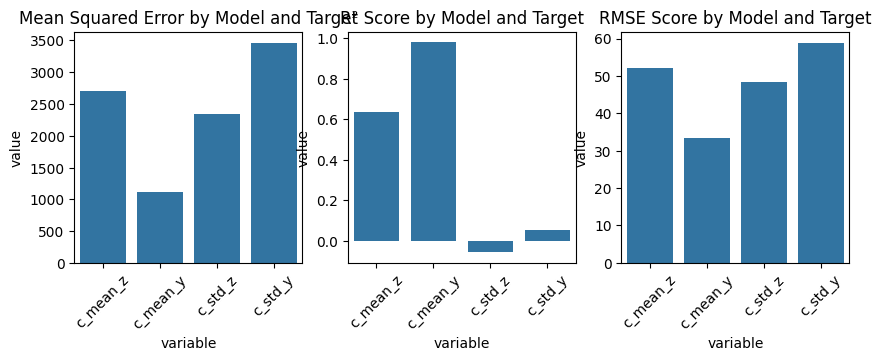

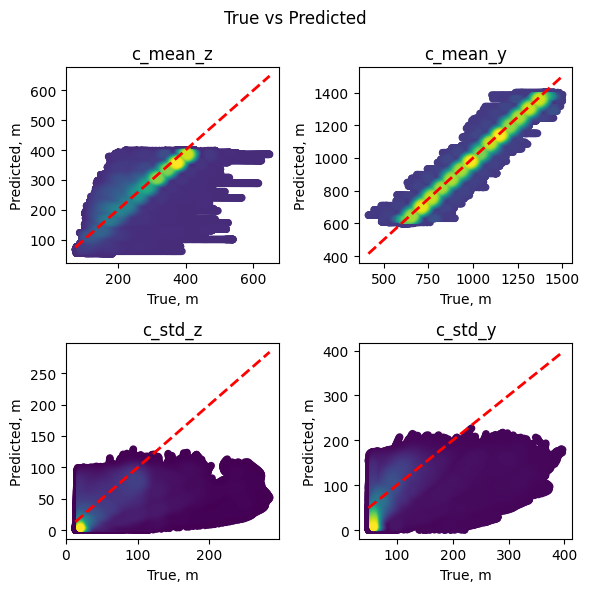

                  mse        r2       rmse
c_mean_z  2707.566659  0.635348  52.034284
c_mean_y  1122.330055  0.979066  33.501195
c_std_z   2336.653869 -0.056428  48.338948
c_std_y   3462.156997  0.052074  58.840097


In [25]:
performance_visualizations(y_pred, y_test_cut)

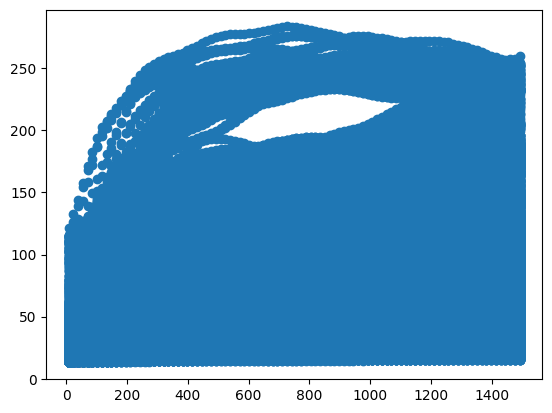

In [26]:
plt.scatter(X_test_cut["distances"], y_test_cut["c_std_z"])

In [27]:
from scipy.interpolate import interpn

In [28]:
def density_scatter(x, y, ax=None, bins=20, cmap='viridis', **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    
    x_copy = x.copy().to_numpy()
    y_copy = y.copy().to_numpy()

    # Calculate the 2D histogram
    data, x_e, y_e = np.histogram2d(x_copy, y, bins=bins, density=True)
    
    # Interpolate the density values for each point
    x_centers = 0.5 * (x_e[1:] + x_e[:-1])
    y_centers = 0.5 * (y_e[1:] + y_e[:-1])
    z = interpn((x_centers, y_centers), data, np.vstack([x_copy, y]).T, 
                method="splinef2d", bounds_error=False)
    
    # Set NaN values to 0
    z[np.where(np.isnan(z))] = 0.0
    
    # Sort the points by density so that densest points are plotted last
    idx = z.argsort()
    x_sorted, y_sorted, z_sorted = x_copy[idx], y_copy[idx], z[idx]
    
    # Create a scatter plot with beauty improvements
    sc = ax.scatter(x_sorted, y_sorted, c=z_sorted, cmap=cmap, alpha=0.7, 
                   s=kwargs.get('s', 30), edgecolor=kwargs.get('edgecolor', 'none'), label ="Результаты LES")
    
    # Set background color and grid
    
    return ax

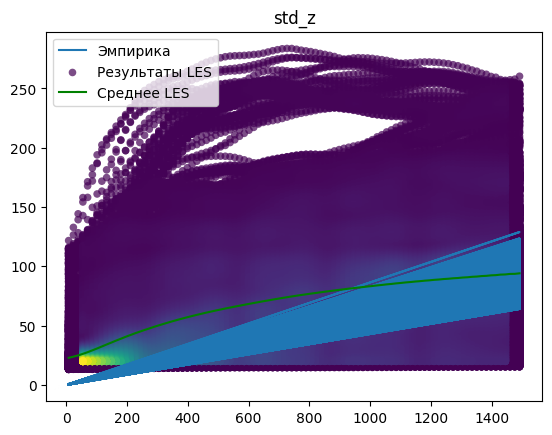

In [31]:
fig, ax = plt.subplots()
plt.title("std_z")
ax.plot(X_test_cut["distances"], std_z, label = "Эмпирика")
ax = density_scatter(X_test_cut["distances"], y_test_cut["c_std_z"], ax)
# plt.plot(X_test["distances"], y_test["c_std_y"], "r", alpha=0.5, label = "Результаты LES")
ax.plot(X_test_cut["distances"].unique(), pd.concat([X_test_cut["distances"], y_test_cut["c_std_z"]], axis=1).groupby("distances").mean()["c_std_z"], 
         "g", label = "Среднее LES")
plt.legend()

In [48]:
y_test_inf =  y_test_cut.loc[X_test_cut[X_test_cut["distances"]>1490].index]
extra_val = X_test_cut.loc[y_test_inf[y_test_inf["c_std_y"]<60].index]
print(extra_val.iloc[0])

Tracer                   2.000000
y                      730.889496
z                      356.372831
u                        7.364581
power                    1.420878
roughness                0.053139
T                      232.539352
sensible_heat_flux      -0.211114
T_grad                   0.070449
distances             1492.187500
experiment_num          24.000000
Name: 141503, dtype: float64


In [ ]:
X_test_cut[(X_test_cut["distances"]>1490) & (X_test_cut["experiment_num"] == 24)]

In [ ]:
y_test_cut.loc[X_test_cut[(X_test_cut["distances"]>1490) & (X_test_cut["experiment_num"] == 24)].index]

In [19]:
# plt.scatter(X["z"], y["c_mean_z"])

In [20]:
# X["z"]

In [21]:
# y["c_mean_z"]

## Briggs parametrisation

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import quantile_transform, power_transform

In [22]:
class TargetPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, near_zero = 1e-1):
        self.near_zero = near_zero

    def fit(self, data: pd.DataFrame, *args):
        self.columns = data.columns
        self.std_y_bias = np.min(data["c_std_y"])
        self.std_z_bias = np.min(data["c_std_z"])
        
        self.std_y_std = np.std(data["c_std_y"])
        self.std_z_std = np.std(data["c_std_z"])

        self.mean_y_mean = np.mean(data["c_mean_y"])
        self.mean_z_mean = np.mean(data["c_mean_z"])

        self.mean_y_std = np.std(data["c_mean_y"])
        self.mean_z_std = np.std(data["c_mean_z"])

        return self

    def transform(self, data: pd.DataFrame):
        data["c_std_y"] -= self.std_y_bias - self.near_zero
        data["c_std_z"] -= self.std_z_bias - self.near_zero
        data["c_std_y"] = np.log(data["c_std_y"])
        data["c_std_z"] = np.log1p(data["c_std_z"])

        # data["c_mean_y"] -= self.mean_y_mean
        # data["c_mean_y"] /= self.mean_y_std
        # mean_y_sign =  np.sign(data["c_mean_y"])
        # self.mean_y_sign = mean_y_sign
        # data["c_mean_y"] = np.abs(data["c_mean_y"])        
        # data["c_mean_y"] = np.log(data["c_mean_y"])

        # # points = np.linspace(0, np.max(data["c_mean_y"]), 200)
        # # quantiles = np.histogram(data["c_mean_y"], points)
        # # quantile_big = quantiles[1][np.argmax(quantiles[0])]
        # # self.mean_y_log_mode = quantile_big

        # # data["c_mean_y"] -= self.mean_y_log_mode
        # data["c_mean_y"] *=mean_y_sign
        data["c_mean_y"] = (data["c_mean_y"] - self.mean_y_mean)/self.mean_y_std
        data["c_mean_z"] = (data["c_mean_z"] - self.mean_z_mean)/self.mean_z_std
        return data
    
    def inverse_transform(self, data: pd.DataFrame):
      
        data["c_std_y"] = np.exp(data["c_std_y"])
        data["c_std_z"] = np.exp(data["c_std_z"])
        data["c_std_y"] += self.std_y_bias - self.near_zero
        data["c_std_z"] += self.std_z_bias - self.near_zero
        
        # mean_y_sign = np.sign(data["c_mean_y"])
        # data["c_mean_y"] *= self.mean_y_sign
        # data["c_mean_y"] = np.exp(data["c_mean_y"])
        # data["c_mean_y"] *= mean_y_sign
        # data["c_mean_y"] *=self.mean_y_std
        # data["c_mean_y"] += self.mean_y_mean
        data["c_mean_y"] = data["c_mean_y"] * self.mean_y_std + self.mean_y_mean
        data["c_mean_z"] = data["c_mean_z"] * self.mean_z_std + self.mean_z_mean
        return data


In [23]:
def func(x, alpha, beta, gamma):
    return alpha*x*(1+beta*x)**gamma

In [24]:
def objective_y(trial):
    param = {
        'alpha': trial.suggest_float("alpha", 0.001, 100),
        'beta': trial.suggest_float('beta', 0.0001, 0.15),
        'gamma': trial.suggest_float('gamma', -0.6, 0.5),

    }
    result = func(x = X_train_cut["distances"], **param)
    loss = root_mean_squared_error(y_train_cut["c_std_y"], result)
    return loss

In [25]:
def objective_z(trial):
    param = {
        'alpha': trial.suggest_float("alpha", 0.001, 100),
        'beta': trial.suggest_float('beta', 0.0001, 0.15),
        'gamma': trial.suggest_float('gamma', -0.6, 0.5),

    }
    result = func(x = X_train_cut["distances"], **param)

    loss = root_mean_squared_error(y_train_cut["c_std_z"], result)
    return loss

In [26]:
t_preproc = TargetPreprocessor()
t_preproc.fit(y)
t_preproc.transform(y_train_cut)

,c_mean_z,c_mean_y,c_std_z,c_std_y
31,2.366520,-0.604905,2.480225,-0.958238
32,2.368393,-0.607107,2.475208,-0.977067
33,2.370741,-0.607521,2.483775,-1.248059
34,2.373219,-0.609887,2.483396,-1.201810
35,2.375593,-0.610602,2.493207,-1.008189
...,...,...,...,...
2322427,1.483268,-0.689904,2.310792,1.332030
2322428,1.483323,-0.690039,2.307835,1.332721
2322429,1.483385,-0.690878,2.311209,1.344350
2322430,1.483382,-0.690586,2.308801,1.349347


array([[<Axes: title={'center': 'c_mean_z'}>,
        <Axes: title={'center': 'c_mean_y'}>],
       [<Axes: title={'center': 'c_std_z'}>,
        <Axes: title={'center': 'c_std_y'}>]], dtype=object)

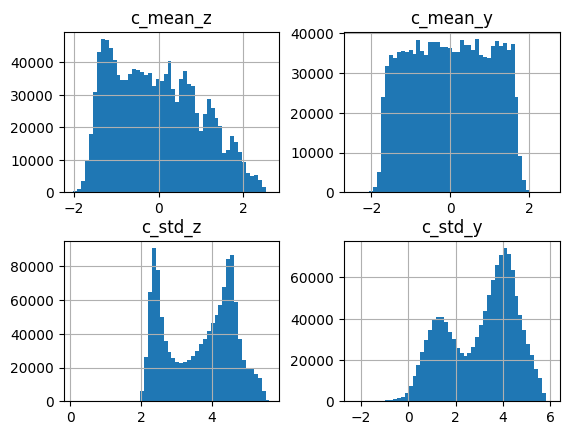

In [28]:
y_train_cut.hist(bins=50)

In [29]:
%%time
study_y = optuna.create_study(study_name=f'briggs-seed{random_seed}')
study_y.optimize(objective_y, n_trials=1000, timeout=7200)

[I 2025-03-04 06:00:27,561] A new study created in memory with name: briggs-seed42
[I 2025-03-04 06:00:27,606] Trial 0 finished with value: 201205.79694410574 and parameters: {'alpha': 95.85391798834709, 'beta': 0.09952791219291765, 'gamma': 0.1495166050363469}. Best is trial 0 with value: 201205.79694410574.
[I 2025-03-04 06:00:27,633] Trial 1 finished with value: 48087.98561344786 and parameters: {'alpha': 10.17841715556948, 'beta': 0.1023533113821234, 'gamma': 0.31848882418015023}. Best is trial 1 with value: 48087.98561344786.
[I 2025-03-04 06:00:27,659] Trial 2 finished with value: 3135.989848493264 and parameters: {'alpha': 17.54629645135439, 'beta': 0.14177104555730435, 'gamma': -0.34764443469135503}. Best is trial 2 with value: 3135.989848493264.
[I 2025-03-04 06:00:27,685] Trial 3 finished with value: 238850.16315812978 and parameters: {'alpha': 48.50000505655018, 'beta': 0.10318402427675921, 'gamma': 0.32660371510345276}. Best is trial 2 with value: 3135.989848493264.
[I 2025

CPU times: user 38.7 s, sys: 249 ms, total: 39 s
Wall time: 38.7 s


In [30]:
%%time
study_z = optuna.create_study(study_name=f'briggs-seed{random_seed}')
study_z.optimize(objective_z, n_trials=1000, timeout=7200)

[I 2025-03-04 06:01:06,269] A new study created in memory with name: briggs-seed42
[I 2025-03-04 06:01:06,295] Trial 0 finished with value: 9872.538636038653 and parameters: {'alpha': 26.49218936795355, 'beta': 0.023182820356149526, 'gamma': -0.3117754977431598}. Best is trial 0 with value: 9872.538636038653.
[I 2025-03-04 06:01:06,321] Trial 1 finished with value: 4764.038383668063 and parameters: {'alpha': 10.280098929693244, 'beta': 0.1323996611629038, 'gamma': -0.16071415821477542}. Best is trial 1 with value: 4764.038383668063.
[I 2025-03-04 06:01:06,346] Trial 2 finished with value: 706361.5966033932 and parameters: {'alpha': 97.8957069271271, 'beta': 0.10673781241250091, 'gamma': 0.40336978692508374}. Best is trial 1 with value: 4764.038383668063.
[I 2025-03-04 06:01:06,372] Trial 3 finished with value: 7230.944924242353 and parameters: {'alpha': 44.77343925185205, 'beta': 0.025279143942160232, 'gamma': -0.5558167937641573}. Best is trial 1 with value: 4764.038383668063.
[I 2025

CPU times: user 38.2 s, sys: 264 ms, total: 38.5 s
Wall time: 38.2 s


In [51]:
print(study_z.best_value)
print(study_z.best_params)

1.006163725918477
{'alpha': 0.05550034105882753, 'beta': 0.08639513664505585, 'gamma': -0.599543208007312}


In [52]:
print(study_y.best_value)
print(study_y.best_params)

1.4153738710826707
{'alpha': 0.050315039474417726, 'beta': 0.12028631297865418, 'gamma': -0.5805599302260466}


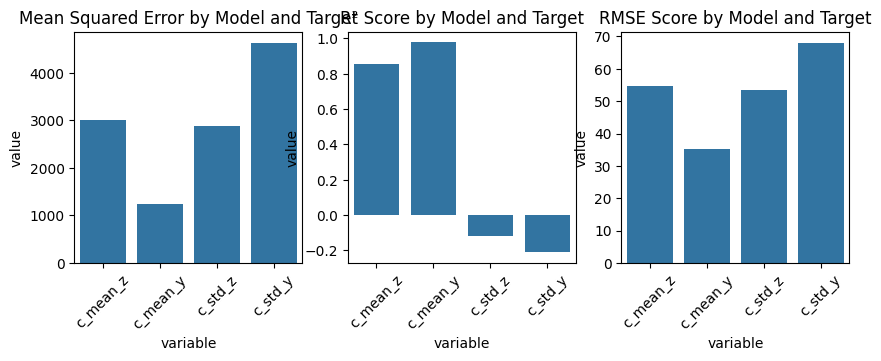

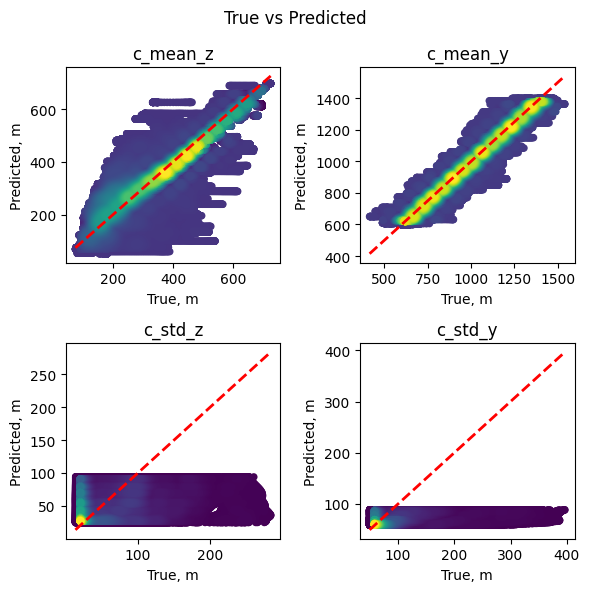

                  mse        r2       rmse
c_mean_z  2999.766562  0.855445  54.770125
c_mean_y  1231.664948  0.977424  35.095084
c_std_z   2869.962955 -0.117757  53.572035
c_std_y   4628.021562 -0.212713  68.029564


In [31]:
result_y = func(x = X_test_cut["distances"], **study_y.best_params)
result_z = func(x = X_test_cut["distances"], **study_z.best_params)

y_pred = {
            "c_mean_z": X_test_cut["z"].to_numpy(),
            "c_mean_y": X_test_cut["y"].to_numpy(),
            "c_std_y": np.array(result_y),
            "c_std_z": np.array(result_z)
        }
t_preproc.inverse_transform(y_pred)
y_pred = {
            "c_mean_z": X_test_cut["z"].to_numpy(),
            "c_mean_y": X_test_cut["y"].to_numpy(),
            "c_std_y": y_pred["c_std_y"],
            "c_std_z": y_pred["c_std_z"]
        }
performance_visualizations(y_pred, y_test_cut)